# About

- `Title:` "Supervised Learning with Quantum-Inspired Tensor Networks. arXiv e-prints, art"
- `Main Author:` Miles E. Stoudenmire
- `Source:` [ArXiv](https://arxiv.org/abs/1605.05775)
- `Publish Date:` 18-05-2017
- `Reviewed Date:` 22-10-2021

## Citation

```latex
@article{stoudenmire2016supervised,
  title={Supervised learning with tensor networks},
  author={Stoudenmire, Edwin and Schwab, David J},
  journal={Advances in Neural Information Processing Systems},
  volume={29},
  year={2016}
}
```

# Imports and settings

In [1]:
%matplotlib inline
%env JAX_ENABLE_X64=1
%env JAX_PLATFORM_NAME=cpu

env: JAX_ENABLE_X64=1
env: JAX_PLATFORM_NAME=cpu


In [2]:
import jax
import jax.numpy as jnp
from jax import jit, grad

In [3]:
import os
import pickle
import time
import itertools

from collections import defaultdict
from functools import reduce, partial
from itertools import accumulate

In [4]:
from typing import Any, List, DefaultDict,\
    Dict, Tuple, Callable, Optional, Iterable

## Types

In [5]:
# type alias
PRNGKeyArray = Any
DeviceArray = jnp.DeviceArray

# Constants

In [6]:
seed = 123     # random seed
bond_dim = 10  # the paper mentions 10, 20 and 120
α = 1e-3       # learning rate
ε = 1e-1       # the allowed truncation error
num_sweeps = 2 # number of sweeps

# Helpers

In [7]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIG_SIZE = 18
HUGE_SIZE = 20

plt.style.use('bmh')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)       # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=HUGE_SIZE)    # fontsize of the figure title
plt.rc('figure', figsize=(8,6))          # figure size
plt.rc('lines', linewidth=3)             # controls line width

In [8]:
def use_svg_display():
    """
    Use the svg format to display a plot in Jupyter.
    """
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


def set_figsize(figsize=(3.5,2.5)):
    """
    Set the figure size for matplotlib.
    """
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """
    Set the axes for matplotlib.
    """
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid(b=True, which='both', color='k', linestyle=(0, (1, 10)))


def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5,2.5), axes=None,
         title=None):
    """
    Plot data points.
    """
    X = jnp.asarray(X)
    Y = jnp.asarray(Y)
    
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    axes.set_title(title)

# Load data and visualise

In [9]:
import datasets

train_images, train_labels, test_images, test_labels = datasets.mnist()

In [10]:
print(f'Train data shape: {train_images.shape} | Test data shape: {test_images.shape}')

Train data shape: (60000, 784) | Test data shape: (10000, 784)


In [11]:
def show_img(img: jnp.ndarray, axes=None, title=None, figsize=(1.5,1.5)) -> None:
    """
    Shows a single image.
    """
    axes = axes if axes else plt.gca()
    set_figsize(figsize)
    axes.imshow(img, cmap='Greys')
    axes.set_xticks([])
    axes.set_yticks([])
    if title:
        axes.set_title(title, fontsize=9)


def show_img_grid(imgs: List[jnp.ndarray], titles: Iterable[str]) -> None:
    """
    Shows a grid of images.
    """
    n = int(jnp.ceil(len(imgs)**0.5))
    _, axes = plt.subplots(n,n)
    for i, (img, title) in enumerate(zip(imgs, titles)):
        show_img(img, axes[i // n][i % n], title)

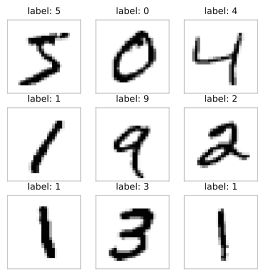

In [12]:
set_figsize((4.5,4.5))

show_img_grid(
    [train_images[i].reshape(28,28) for i in range(9)],
    [f"label: {jnp.argmax(train_labels[i])}" for i in range(9)]
)

# Downscaling images as in paper

In [13]:
def resize(img_vec: jnp.ndarray, shape: Tuple[int,int]) -> jnp.ndarray:
    """
    Resizing the image vector.
    """
    orig_size = jnp.sqrt(img_vec.size).astype(int)
    img = img_vec.reshape(orig_size, orig_size)
    img = jax.image.resize(img, shape, method='nearest')
    return img.reshape(-1)

In [14]:
new_shape = (14,14)

resize_vmap = partial(resize, shape=new_shape)

train_images_scaled = jax.vmap(resize_vmap)(train_images)
test_images_scaled = jax.vmap(resize_vmap)(test_images)

In [15]:
print(f'Train data shape: {train_images_scaled.shape} | Test data shape: {test_images_scaled.shape}')

Train data shape: (60000, 196) | Test data shape: (10000, 196)


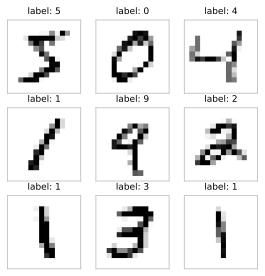

In [16]:
set_figsize((4.5,4.5))

show_img_grid(
    [train_images_scaled[i].reshape(new_shape) for i in range(9)],
    [f"label: {jnp.argmax(train_labels[i])}" for i in range(9)]
)

# Feature Map

As per the paper.

In [17]:
def feature_map(x: DeviceArray) -> DeviceArray:
    """Definine a feature map per pixel"""
    return jnp.array([
        jnp.cos(0.5*jnp.pi*x), 
        jnp.sin(0.5*jnp.pi*x)
    ])

In [18]:
train_data = jax.vmap(feature_map)(train_images_scaled).transpose(0,2,1)  # exchanging axes for convenience
test_data = jax.vmap(feature_map)(test_images_scaled).transpose(0,2,1)    # same as above

In [19]:
print(f'Train data shape: {train_data.shape} | Test data shape: {test_data.shape}')

Train data shape: (60000, 196, 2) | Test data shape: (10000, 196, 2)


## MPS Utilities

In [20]:
def random_mps(
        key: PRNGKeyArray,
        initializer: Callable,
        size: int,
        local_dim: int,
        bond_dim: int,
        labels_dim: Optional[int]=None,
        dtype: Optional[jnp.double]=jnp.double
    ) -> List[DeviceArray]:
    """
    Generate a random MPS where each core tensor
    is drawn according to the initializer (see JAX docs). 
    """
    left   = (1,local_dim, bond_dim, labels_dim) if labels_dim else (1,local_dim, bond_dim)
    right  = (bond_dim, local_dim, 1)
    middle = (bond_dim, local_dim, bond_dim)

    if size < 2:
        raise ValueError('Expectetd at least 2 sites for the MPS')
    elif size == 2:
        shapes = [left, right]
    else:
        shapes = [left] + [middle]*(size-2) + [right]

    # generate multiple keys, so all tensors are different
    keys = jax.random.split(key, num=size)
    return [initializer(*params, dtype=dtype) for params in zip(keys, shapes)]

In [21]:
def flip_left_right(
        mps: List[DeviceArray], 
        axes: Optional[Tuple[int,int]]=(0,2)
    ) -> List[DeviceArray]:
    """
    A helper to flip a mps from left to right.
    The left and right legs are interchanged.
    The assumed indexing is as follows:
    0 --o-- 2     2 --o-- 0 
        |     =>      |
        1             1
    """
    return [tensor.swapaxes(*axes) for tensor in reversed(mps)]

In [22]:
key = jax.random.PRNGKey(seed)

# spliting the key
key_params, key_run = jax.random.split(key, num=2)

# getting the parameters
num_samples, num_features, dim_features = train_data.shape
num_classes = train_labels.shape[1]

# the initializer, a.k.a. He
initializer = jax.nn.initializers.variance_scaling(scale=2, mode="fan_in", distribution="uniform") 
# initializer = partial(jax.random.uniform, minval=-1, maxval=1)  <- old school

# generating a random mps according to the initialiser
mps = random_mps(
    key_params, 
    initializer, 
    size=num_features, 
    local_dim=dim_features, 
    bond_dim=bond_dim,
    labels_dim=num_classes
)

In [23]:
print(f'The MPS dimensions: size={num_features}, local_dim={dim_features}, bond_dim={bond_dim}')
print(f'Total number of paramters: {bond_dim**2 * dim_features * num_features}')

The MPS dimensions: size=196, local_dim=2, bond_dim=10
Total number of paramters: 39200


# Bond Truncation

In [24]:
@jit
def suggest_truncation(
        λ: jnp.ndarray,
        ε: Optional[float]=1e-3  # truncation error tolerance
    ) -> Tuple[jnp.ndarray, jnp.ndarray, int]:
    """
    Suggest a truncation index of the spectrum 
    such that the truncation error is lower than ε.
    The spectrum is assumed to be in the decreasing order.
    """
    cum_sums = jnp.cumsum(λ / λ.sum())
    return jnp.searchsorted(cum_sums, 1-ε)

# Training

In [25]:
@jit
def project_sample(
        mps: List[DeviceArray], 
        sample: List[DeviceArray]
    ) -> List[DeviceArray]:
    """
    A helper to project a single sample onto the mps
    sites, e.g. contracting the local dimension only.
    """
    mult = lambda t, s: jnp.einsum('piq...,i->pq...', t, s)
    return jax.tree_multimap(mult, mps, list(sample))

Precompute data to reduce complexity - see last paragraph on p.4 for more details. Note, as we start from the left most pair of sites, only the right part, i.e. the "right wings", are precomputed - hence starting from from the position 2.

In [26]:
@jit
def compute_right_wings(mps, train_data):
    # get the projections of samples onto the mps sites
    # start with 2 as the first pair of indices are occupied by the bond tensor B
    right_projs = jax.vmap(partial(project_sample, mps[2:]))(train_data[:,2:,:])
    # helper to contract neighbouring sites
    mult = lambda x, y: jnp.einsum('...pi,...iq->...pq', x, y)
    # get the cumulative products computed from left to right
    # swapaxes axes are (1,2), as the first index in each tensor is the sample size
    cum_prods = accumulate(flip_left_right(right_projs, axes=(1,2)), mult)
    # reverse before return so the indexing is natural again
    # unfortunately we can't access the iterator accumulate backwords
    return list(x.squeeze() for x in cum_prods)[::-1]

In [27]:
# def cross_entropy(preds, targets):
#     """Multinomial cross entropy"""
#     return -jnp.mean(jnp.sum(preds * targets, axis=1))

# def loss(B: DeviceArray, data: Tuple[DeviceArray, DeviceArray]):
#     """A modified loss function"""
#     inputs, targets = data
#     preds = jnp.einsum('pijq...,mpijq->m...', B, inputs)
#     logprobas = jax.nn.log_softmax(preds, axis=1)
#     return cross_entropy(logprobas, targets)

def loss(B: DeviceArray, data: Tuple[DeviceArray, DeviceArray]):
    """Loss function with respect to B - Fig.7a"""
    inputs, targets = data
    preds = jnp.einsum('...l,m...->ml', B, inputs)
    err = (targets - preds) ** 2
    return 0.5 * jnp.mean(jnp.sum(err, axis=1))
    # return 0.5 * jnp.mean(jnp.log(jnp.power(err, 2) + 1))

In [28]:
max_bond = bond_dim

In [ ]:
losses = {}

for sweep in range(num_sweeps):

    print('*'*80)
    print(f'Current sweep: {sweep}')
    print('*'*80)

    # a precomputed list of all right wings
    # see last paragraph on p.4 for the motivation
    print('Precomuting the projections...', end=' ')
    right_wings = compute_right_wings(mps, train_data)
    print('Done!')

    losses_ = []

    for pos in range(len(mps)-1):

        # bond tensor - Fig.6a
        B = jnp.einsum('pji...,ikq->pjkq...', mps[pos], mps[pos+1])

        # getting the new data inputs
        inputs = train_data[:,pos:pos+2]

        # composing a tensor Φ - Fig.6b
        if pos == 0:
            right_wing = right_wings[pos]
            # because there is no left wing, insert a dummy index p instead
            inputs = jnp.expand_dims(inputs, axis=1)
            Φ = jnp.einsum('...pij,...q->...pijq', inputs, right_wing)
        elif pos == len(mps)-2:
            # because there is no right wing, insert a dummy index q instead
            inputs = jnp.expand_dims(inputs, axis=3)
            Φ = jnp.einsum('...p,...ijq->...pijq', left_wing, inputs)
        else:
            right_wing = right_wings[pos]
            Φ = jnp.einsum('...p,...ij,...q->...pijq', left_wing, inputs, right_wing)

        # compute the gradient update - Fig.6(c-d)
        ΔB = grad(loss)(B, data=(Φ, train_labels))
        
        # update the bond tensor - Fig.7a
        B += α * ΔB
    
        # SVD
        p,i,j,q,l = B.shape
        U, λ, Vh = jnp.linalg.svd(B.reshape(p*i,-1), full_matrices=False)

        # cutting off the bond dimension
        if λ.size > max_bond:
            # max_bond = suggest_truncation(λ, ε)  # adaptive bond dimension
            U  = U[:,:max_bond]
            λ  = λ[:max_bond]
            Vh = Vh[:max_bond,:]

        # updating mps tesnors - Fig.7b
        mps[pos] = U.reshape(p,i,-1)  # current position
        mps[pos+1] = jnp.einsum('i,ij->ij', λ, Vh).reshape(-1,j,q,l)  # next position

        # project input samples onto the new tensor at current position and update the left wing - Fig.7c
        inputs_curr = train_data[:,[pos],:]  # data at current position only
        mps_curr = [mps[pos]]                # mps (consisting of 1 tensor) at current position
        proj_curr = jax.vmap(partial(project_sample, mps_curr))(inputs_curr)
        if pos == 0:
            left_wing = jnp.asarray(
                proj_curr
            ).squeeze(axis=(0,2)) # 0 index is due to len(MPS) = 1
                                  # 2 index is due to the left most dim of the first tensor
        else:
            left_wing = jnp.einsum(
                '...p,...pq->...q', 
                left_wing, 
                jnp.asarray(proj_curr).squeeze(axis=(0)) # 0 index is due to len(MPS) = 1
            )

        losses_.append(loss(B, data=(Φ, train_labels)))
        print(f'Updated site: {pos:<5}\t|\tLoss: {losses_[-1]:<10.7f}\t|\tBond Dim: {max_bond:<5}')

    # store the loss
    if (sweep % 2) == 0:
        losses[sweep] = losses_
    else:
        losses[sweep] = losses_[::-1]  # on odd sweeps flip the losses
        
    # prepare everything for the next sweep
    mps = flip_left_right(mps)
    train_data = jnp.flip(train_data, axis=1)
    train_labels = jnp.flip(train_labels, axis=0)

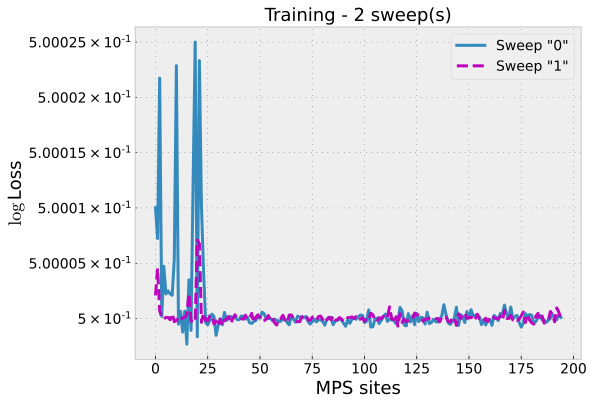

In [30]:
plot(jnp.arange(len(mps)-1), [jnp.array(v) for v in losses.values()], 
     xlabel='MPS sites', ylabel='$\log$Loss',
     legend=[f'Sweep "{i}"' for i in losses.keys()],
     figsize=(8,6),
     yscale='log',
     title=f'Training - {len(losses)} sweep(s)'
)

# Predicting Labels

In [31]:
def predict_labels(mps, inputs):
    # project all test instances onto the mps 
    inputs_proj = jax.vmap(partial(project_sample, mps))(inputs)
    # reduce (full contraction)
    preds = reduce(lambda x,y: jnp.einsum('mpi...,miq...->mpq...', x, y), inputs_proj)
    # get predicted class probabilities
    probas = jax.nn.softmax(preds.squeeze(), axis=1)
    return jnp.argmax(probas, axis=1).astype(int)

In [32]:
pred_train_classes = predict_labels(mps, train_data)
pred_test_classes = predict_labels(mps, test_data)

In [33]:
from sklearn import metrics

import warnings
warnings.simplefilter('ignore', UserWarning)

In [34]:
train_classes = jnp.argmax(train_labels, axis=1)
test_classes = jnp.argmax(test_labels, axis=1)

print(f'Classification report Train:\n\n'
      f'{metrics.classification_report(pred_train_classes, train_classes)}\n')

Classification report Train:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.49      0.11      0.18     29845
           2       0.00      0.00      0.00         0
           3       0.50      0.10      0.17     30155
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.11     60000
   macro avg       0.10      0.02      0.03     60000
weighted avg       0.49      0.11      0.17     60000




In [35]:
print(f'Classification report Test:\n\n'
      f'{metrics.classification_report(pred_test_classes, test_classes)}\n')

Classification report Test:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.49      0.11      0.18      5048
           2       0.00      0.00      0.00         0
           3       0.51      0.10      0.17      4952
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.11     10000
   macro avg       0.10      0.02      0.04     10000
weighted avg       0.50      0.11      0.18     10000




In [36]:
jnp.unique(pred_test_classes)

DeviceArray([1, 3], dtype=int64)